In [111]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import pandas as pd
from scipy.spatial.distance import pdist, squareform

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric, GaussianStochasticMetric

# My code. 
import generators

# The parameters I ran the experiment with. 
PROMPT = "Once upon a time"
PROMPT_LENGTH = len(PROMPT.split(" "))
SEEDS = [1, 2, 3]
TEMPERATURES = [0, 0.5, 1.0, 2.0]
NUM_EXPERIMENTS = 200
NUM_TOKENS = 20



# Of shape (Temperature, Seed, Num_Experiments, Num_Classes, 64)
per_trial_data = np.load('ranging_temperature_across_k_seeds/experiment200N_per_trial_tensor.npy')
per_trial_data.shape

(4, 3, 200, 23, 64)

In [148]:
# Take the average over the number of experiments. 
mean_trajectories = np.mean(per_trial_data, 2)
print(mean_trajectories.shape)

# Then reshape the trajectories into (Variables, Time points, Neurons)
reshaped = mean_trajectories.reshape(len(TEMPERATURES) * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, 64)

print(reshaped.shape)

# Array of [ (Time points, Neurons), ... ]
Xs = []
for i in range(reshaped.shape[0]):
    Xs.append(reshaped[i])


(4, 3, 23, 64)
(12, 23, 64)


In [149]:
### LINEAR PROCRUSTES DISTANCE ###

alphas = [0, 0.5, 1] # alphas to use for linear metric
linear_distances = [] # array of distances

for alpha in alphas:
    metric = LinearMetric(alpha=alpha, score_method="euclidean")
    dist, _ = metric.pairwise_distances(Xs)
    linear_distances.append(dist)


Parallelizing 66 distance calculations with 8 processes.


Computing distances: 100%|██████████| 66/66 [00:01<00:00, 44.54it/s]

Parallelizing 66 distance calculations with 8 processes.



Computing distances: 100%|██████████| 66/66 [00:01<00:00, 55.50it/s]

Parallelizing 66 distance calculations with 8 processes.



Computing distances: 100%|██████████| 66/66 [00:01<00:00, 65.61it/s]


In [ ]:


def cov3d(data):
    '''
    Calculates the covariance for a 3D array.
    Iterates over L (some number of parameters or samples) and calculates the covariance.
    '''
    if(len(data.shape) != 3):
        print("ERROR NOT 3D")
        return None

    L, N, M = data.shape
    covar_matrices = np.zeros((L, M, M))
    for i in range(L):
        covar_matrices[i] = np.cov(data[i, :, :], rowvar=False)
    
    return covar_matrices


# I want to give it a shape 23, 12, 64 so I can get 23, 64, 64
# because my mean_trajectories are shape

Xz = [] # gaussian input

test = per_trial_data.reshape(12, 23, 200, 64) # TODO: I don't know if this is right
for i in range(12):
    covar = cov3d(test[i])
    Xz.append((Xs[i], covar))

# Group with the means. 

# gaussian_distances = []
metric = GaussianStochasticMetric(alpha=1, init='rand', n_restarts=50)
dist, _ = metric.pairwise_distances(Xz)


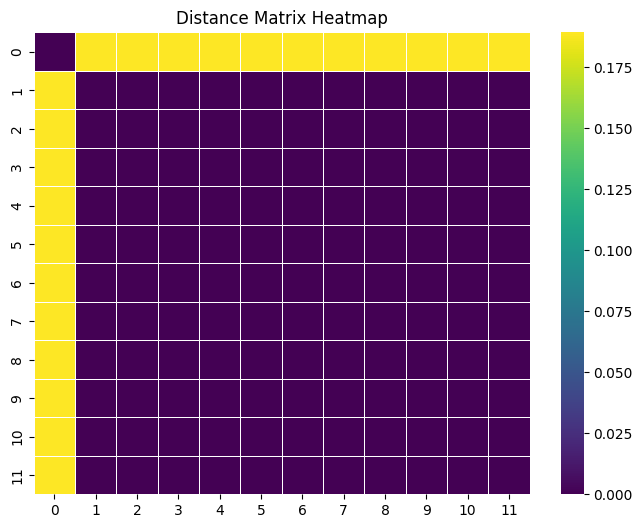

In [103]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(linear_distances[0], cmap='viridis', annot=False, fmt=".2f", linewidths=.5)

plt.title('Distance Matrix Heatmap')
plt.show()